In [95]:
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV 
from statsmodels.tsa.seasonal import STL

In [90]:
df = pd.read_csv("cleaned data1.csv")
df.head()

,date,rate,temp,log_sale,stat_price,sale_res,sales
0,1/1/2001,4.3,28.4,8.539483,0.001122,0.018296,5112.70176
1,2/1/2001,4.4,35.1,8.326987,0.000862,0.028896,4133.94364
2,3/1/2001,4.5,35.3,8.324770,-0.000719,0.024109,4124.78653
3,4/1/2001,4.5,54.3,8.161565,-0.000890,0.001162,3503.66720
4,5/1/2001,4.6,60.0,8.016586,-0.000380,-0.004758,3030.81191


In [91]:
df.set_index("date", inplace=True)

In [92]:
df.index = pd.to_datetime(df.index)

In [93]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 264 entries, 2001-01-01 to 2022-12-01
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   rate        264 non-null    float64
 1   temp        264 non-null    float64
 2   log_sale    264 non-null    float64
 3   stat_price  264 non-null    float64
 4   sale_res    264 non-null    float64
 5   sales       264 non-null    float64
dtypes: float64(6)
memory usage: 14.4 KB


In [53]:
from scipy.stats import pearsonr

In [54]:
# this computes the correlation coefficients
corr = df.corr(method=lambda x, y: pearsonr(x, y)[0]) 
corr

,rate,temp,log_sale,stat_price,sale_res
rate,1.000000,0.030797,0.037779,-0.034917,0.105640
temp,0.030797,1.000000,-0.273698,0.023756,-0.044821
log_sale,0.037779,-0.273698,1.000000,-0.019605,0.288785
stat_price,-0.034917,0.023756,-0.019605,1.000000,0.018468
sale_res,0.105640,-0.044821,0.288785,0.018468,1.000000


In [97]:
result = STL(df['sales']).fit()
trend = result.trend
seasonal = result.seasonal

### Split Data

In [228]:
X = df.drop(labels=['sale_res','log_sale','sales'], axis=1)
y = df['sale_res']

In [229]:
# Split the data into train and test sets
X_train = X[X.index < '2021-01-01']
X_test = X[X.index >= '2021-01-01']
y_train = y[y.index < '2021-01-01']
y_test = y[y.index >= '2021-01-01']

In [230]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(240, 3)
(24, 3)
(240,)
(24,)


### Scale the data

In [231]:
from sklearn.preprocessing import MinMaxScaler

In [232]:
scaler = MinMaxScaler()
#fit only on the training data
scaler.fit(X_train)
# Transform training data
X_train_scal = scaler.transform(X_train)

# Transform test data using same scaler
X_test_scal = scaler.transform(X_test)


### SVR Model

In [182]:
from sklearn.model_selection import GridSearchCV 


In [216]:
# defining parameter range 
param_grid = {'kernel': ['rbf'],
              'C': [0.1, 1, 10,100,1000],
              }
#Create a time series cross-validation splitter
tscv = TimeSeriesSplit(n_splits=5, max_train_size=len(X_train_scal))

grid = GridSearchCV(SVR(), param_grid,cv=tscv,return_train_score=True) 

# fitting the model for grid search 
grid.fit(X_train_scal, y_train)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=240, n_splits=5, test_size=None),
             estimator=SVR(),
             param_grid={'C': [0.1, 1, 10, 100, 1000], 'kernel': ['rbf']},
             return_train_score=True)

In [217]:
# print best parameter after tuning 
print(grid.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid.best_estimator_) 

{'C': 1, 'kernel': 'rbf'}
SVR(C=1)


In [218]:
svr = SVR()

In [219]:
y_pred_svr = grid.predict(X_test_scal) 

# print performance report
rmse = sqrt(mean_squared_error(y_test, y_pred_svr))
mse = mean_squared_error(y_test, y_pred_svr)
mae = mean_absolute_error(y_test, y_pred_svr)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0013405733530966833
Root Mean Squared Error (RMSE): 0.03661384100441639
Mean Absolute Error: 0.029901362575531065


In [108]:
trend.y_test = trend[trend.index >= '2021-01-01']

In [110]:
seasonal.y_test = seasonal[seasonal.index >= '2021-01-01']

In [136]:
# Reconstruct the forecast
reconstructed_forecast = y_pred_svr + trend.y_test + seasonal.y_test

In [137]:
reconstructed_forecast

date
2021-01-01    5871.831356
2021-02-01    5218.662288
2021-03-01    4533.442224
2021-04-01    3820.618778
2021-05-01    3668.440213
2021-06-01    4443.997933
2021-07-01    5634.068670
2021-08-01    5619.683813
2021-09-01    4405.016842
2021-10-01    3640.446411
2021-11-01    4084.518902
2021-12-01    5295.262536
2022-01-01    5900.272648
2022-02-01    5271.120183
2022-03-01    4474.501758
2022-04-01    3750.496466
2022-05-01    3669.278422
2022-06-01    4545.199511
2022-07-01    5616.681360
2022-08-01    5689.017020
2022-09-01    4331.628690
2022-10-01    3582.809304
2022-11-01    4070.240636
2022-12-01    5339.854021
dtype: float64

Text(0.5, 0, 'Date')

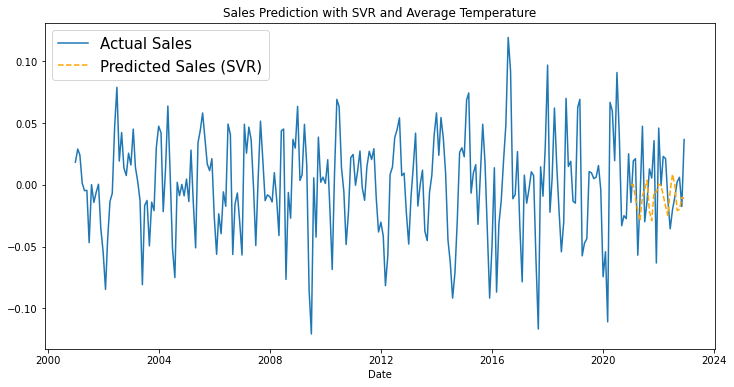

In [187]:
# Visualize the results
plt.figure(figsize=(12,6))
plt.plot(df['sale_res'], label='Actual Sales')
plt.plot(y_test.index,y_pred_svr, label='Predicted Sales (SVR)', linestyle='dashed', color='orange')
plt.title('Sales Prediction with SVR and Average Temperature')
plt.legend(fontsize=15)
plt.xlabel('Date')

### SARIMAX

In [139]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from math import sqrt

In [140]:
import itertools
import warnings 
warnings.simplefilter("ignore")

In [220]:
# Fitting the SARIMAX model
order = (1, 0, 1)  # Replace with your chosen order (p, d, q)
seasonal_order = (1, 1, 1, 12)  # Replace with your chosen seasonal order (P, D, Q, s)

model = SARIMAX(endog=y_train, exog=X_train, order=order, seasonal_order=seasonal_order,freq = 'MS')
results = model.fit()

# Making predictions on the test set
y_pred = results.get_forecast(steps=len(y_test), exog=X_test)
y_pred_mean = y_pred.predicted_mean

# Evaluate the model (RMSE in this example)
rmse = sqrt(mean_squared_error(y_test, y_pred_mean))
print(f'Root Mean Squared Error (RMSE): {rmse}')


Root Mean Squared Error (RMSE): 0.031185150405810044


In [221]:
mae = mean_absolute_error(y_test, y_pred_mean)
mse = mean_squared_error(y_test, y_pred_svr)
print(f'Mean Squared Error (MAE): {mae}')
print(f'Mean Squared Error: {mse}')

Mean Squared Error (MAE): 0.023949670895135108
Mean Squared Error: 0.0013405733530966833


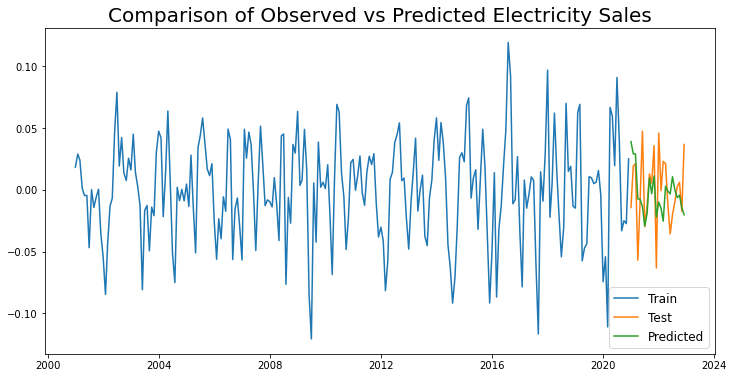

In [143]:
plt.figure(figsize=(12, 6))
plt.title('Comparison of Observed vs Predicted Electricity Sales', fontsize=20)
plt.plot(y_train, label='Train')
plt.plot(y_test, label='Test')
plt.plot(y_pred_mean, label='Predicted')
plt.legend(fontsize=12)
plt.show()

### XGBoost

In [166]:
import xgboost as xgb
from sklearn.model_selection import RandomizedSearchCV

In [158]:
param_grid_xgb = {
    'max_depth': [3, 5, 6, 10, 15, 20],
    'learning_rate': [0.01, 0.1, 0.2, 0.3],
    'subsample': np.arange(0.5, 1.0, 0.1),
    'colsample_bytree': np.arange(0.4, 1.0, 0.1),
    'colsample_bylevel': np.arange(0.4, 1.0, 0.1),
    'n_estimators': [100, 500, 1000]
}


In [164]:
param_grid_xgb= {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'colsample_bytree': [0.1,0.4, 1.0]
}

In [167]:
xgb = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

In [222]:
grid_xgb = GridSearchCV(estimator=xgb, param_grid=param_grid_xgb,return_train_score=True) 

# fitting the model for grid search 
grid_xgb.fit(X_train_scal, y_train)
                           

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    gamma=None, gpu_id=None, grow_policy=None,
                                    importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bin=None,
                                    max_cat_to_o..._step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n

In [223]:
# print best parameter after tuning 
print(grid_xgb.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid_xgb.best_estimator_) 

{'colsample_bytree': 1.0, 'learning_rate': 0.1, 'n_estimators': 50}
XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1.0,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
             importance_type=None, interaction_constraints='',
             learning_rate=0.1, max_bin=256, max_cat_to_onehot=4,
             max_delta_step=0, max_depth=6, max_leaves=0, min_child_weight=1,
             missing=nan, monotone_constraints='()', n_estimators=50, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42,
             reg_alpha=0, reg_lambda=1, ...)


In [224]:
y_pred_xgb = grid_xgb.predict(X_test_scal) 

# print performance report
rmse = sqrt(mean_squared_error(y_test,y_pred_xgb))
mse = mean_squared_error(y_test,y_pred_xgb)
mae = mean_absolute_error(y_test,y_pred_xgb)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0009428515775255835
Root Mean Squared Error (RMSE): 0.030705888320085833
Mean Absolute Error: 0.024783255124054108


Text(0.5, 0, 'Date')

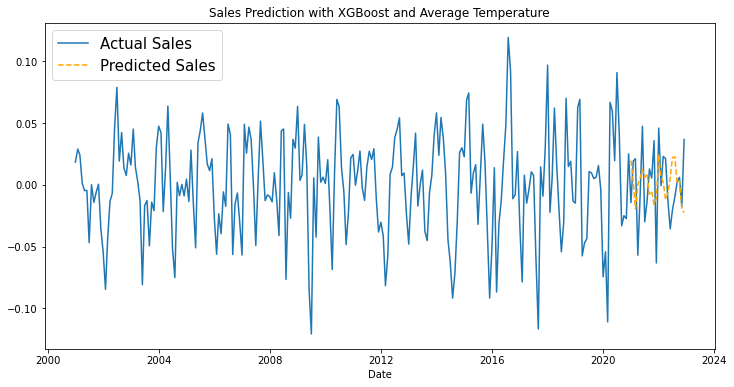

In [171]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['sale_res'], label='Actual Sales')
plt.plot(y_test.index, y_pred_xgb, label='Predicted Sales', linestyle='dashed', color='orange')
plt.title('Sales Prediction with XGBoost and Average Temperature')
plt.legend(fontsize=15)
plt.xlabel('Date')

### Random Forest

In [233]:
param_grid_RF = {
    'n_estimators': [50, 100, 200],
    'max_features': ['auto', 'sqrt'],
    'bootstrap': [True],
    'criterion' : ['mse'],
    'n_jobs': [-1]
}

In [234]:
grid_RF = GridSearchCV(RandomForestRegressor(), param_grid_RF, return_train_score=True ) 

# fitting the model for grid search 
grid_RF.fit(X_train_scal, y_train) 

GridSearchCV(estimator=RandomForestRegressor(),
             param_grid={'bootstrap': [True], 'criterion': ['mse'],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [50, 100, 200], 'n_jobs': [-1]},
             return_train_score=True)

In [235]:
# print best parameter after tuning 
print(grid_RF.best_params_) 

# print how our model looks after hyper-parameter tuning 
print(grid_RF.best_estimator_) 

{'bootstrap': True, 'criterion': 'mse', 'max_features': 'sqrt', 'n_estimators': 200, 'n_jobs': -1}
RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=-1)


In [236]:
y_pred_RF = grid_RF.predict(X_test_scal) 

# print performance report
rmse = sqrt(mean_squared_error(y_test,y_pred_RF))
mse = mean_squared_error(y_test,y_pred_RF)
mae = mean_absolute_error(y_test,y_pred_RF)

print(f'Mean Squared Error: {mse}')
print(f'Root Mean Squared Error (RMSE): {rmse}')
print(f'Mean Absolute Error: {mae}')

Mean Squared Error: 0.0007284281258470518
Root Mean Squared Error (RMSE): 0.026989407660173867
Mean Absolute Error: 0.02262764880395833


In [240]:
rfr = RandomForestRegressor(max_features='sqrt', n_estimators=200, n_jobs=-1)

In [241]:
rfr.fit(X_train_scal, y_train)
# Extract feature importance
importances = rfr.feature_importances_

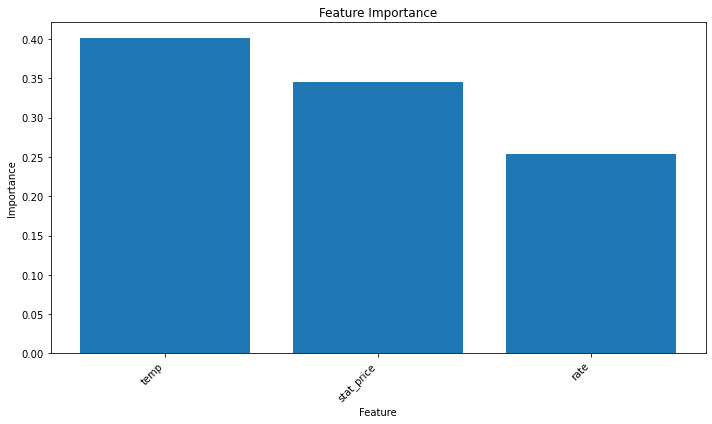

In [242]:
# Sort features by importance in descending order
features = X
sorted_features = sorted(zip(importances, features), reverse=True)

# Create a bar plot to visualize feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(sorted_features)), [importance for importance, _ in sorted_features])
plt.xticks(range(len(sorted_features)), [feature for _, feature in sorted_features], rotation=45, ha="right")
plt.title("Feature Importance")
plt.xlabel("Feature")
plt.ylabel("Importance")
plt.tight_layout()
plt.show()


In [239]:
# Extract feature importance
importances = grid_RF.feature_importances_


AttributeError: 'GridSearchCV' object has no attribute 'feature_importances_'

Text(0.5, 0, 'Date')

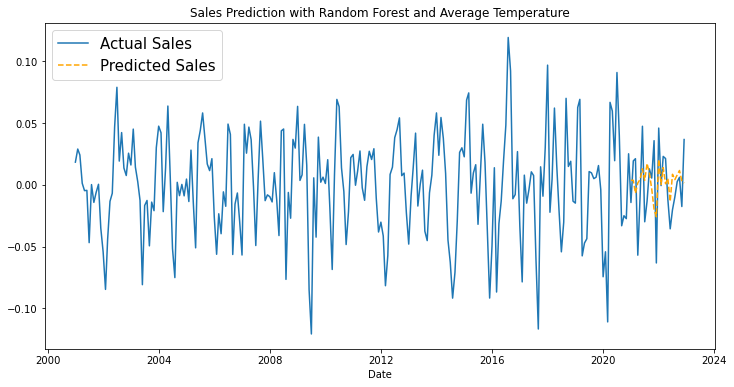

In [237]:
# Visualize the results
plt.figure(figsize=(12, 6))
plt.plot(df['sale_res'], label='Actual Sales')
plt.plot(y_test.index, y_pred_RF, label='Predicted Sales', linestyle='dashed', color='orange')
plt.title('Sales Prediction with Random Forest and Average Temperature')
plt.legend(fontsize=15)
plt.xlabel('Date')

In [238]:
y_pred_RF

array([ 0.00364922,  0.00357863, -0.00695439,  0.00138502,  0.00441033,
        0.01291617,  0.00361053,  0.01727977,  0.00914249, -0.00333661,
       -0.01999333, -0.0258977 ,  0.02051926,  0.00017928,  0.0138612 ,
        0.00080672,  0.00511395, -0.0135462 ,  0.00847847,  0.00416843,
        0.00792307,  0.01153898,  0.00321166,  0.00132331])